In [1]:
import ROOT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep

In [2]:
file = 'ttbar.root'
df = ROOT.RDataFrame("Events", file)

Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


In [3]:
# Define scuared generator weight to help compute error bars 
df = df.Define("genWeight2", "pow(genWeight, 2)")

In [4]:
# Function to if event has BHadrons
LeadHadron ="""
pair<int, float> LeadHadron(
ROOT::RVec<int> FlavourID, 
ROOT::RVec<float> ParticlePt)
{
    int nPart = FlavourID.size();
    int LeadId = 0;
    float LeadPt = 0.0;

    // Loop through particles
    for (int idx = 0; idx < nPart; idx++){
        int CandVal = FlavourID[idx];
        float CandPt = ParticlePt[idx];

        // Check if the particle is B hadron
        if ((abs(CandVal) >= 100 ) && (CandPt > LeadPt)){
            LeadId = CandVal;
            LeadPt = CandPt;
        }
    }
    return std::make_pair(LeadId, LeadPt);
}

"""

ROOT.gInterpreter.Declare(LeadHadron)

True

In [5]:
# Making a function to find b hadrons, since declaring std::vector breaks the backend somehow...
find_b_hadrons = """
bool FindB(
int LeadHadron_pdgId
){
std::vector<int> Mesons = {-511, -513, -521, -523, -531, -533};
bool IsMeson = std::find(Mesons.begin(), Mesons.end(), LeadHadron_pdgId) != Mesons.end();
bool IsBaryon = (LeadHadron_pdgId >= 5000 && LeadHadron_pdgId < 6000);
bool BExists = IsMeson || IsBaryon;
return BExists;
}
"""
ROOT.gInterpreter.Declare(find_b_hadrons)

True

In [6]:
# Define the leading hadron pdgId and pt if it includes b quark 
df = (df.Define("LeadHadron", "LeadHadron(GenPart_pdgId, GenPart_pt)")
        .Define("LeadHadron_pdgId", "LeadHadron.first")
        .Define("LeadHadron_pt", "LeadHadron.second")
        .Define("HasB", "FindB(LeadHadron_pdgId)"))

In [7]:
# Loop through semileptonic decay chains returns pair of flavours within decay chain and BHadron pt for binning 
# Only computed from largest hadron
semileptonic_decay = """
pair<ROOT::RVec<ROOT::RVec<int>>, pair<float, int>> SemileptonicDecay(
ROOT::RVec<int> ParticleFlavour,
ROOT::RVec<int> MotherIdx,
ROOT::VecOps::RVec<UShort_t> statusFlags,
ROOT::RVec<float> PartPt
){

int nParticles = ParticleFlavour.size();
ROOT::RVec<ROOT::RVec<int>> ReturnVector;
float ReturnPt = 0;
int Return_pdgId;
std::vector<int> Mesons = {-511, -513, -521, -523, -531, -533};


// loop through every particle in event
for (int ii = 0; ii < nParticles; ii++){
    int Flavour = ParticleFlavour[ii];

    // If the particle is lepton
    if ((abs(Flavour) == 13) || (abs(Flavour) == 11)){


        // Initialize the while loop
        int Idx = ii;
        bool IsMeson = false;
        bool IsBHadron = false;
        ROOT::RVec<int> CandVector;
        CandVector.push_back(Flavour);
        bool FromHardProcess = (statusFlags[Idx] >> 8) & 1;

        int Mother = MotherIdx[Idx];
        int MotherFlavour = ParticleFlavour[Mother];
        bool MotherIsMeson = std::find(Mesons.begin(), Mesons.end(), MotherFlavour) != Mesons.end();
        bool MotherIsBHadron = (MotherIsMeson || (MotherFlavour >= 5000 && MotherFlavour < 6000));


        // Trace back the decay chain
        while ((!IsBHadron || (IsBHadron && MotherIsBHadron)) && !FromHardProcess && Idx != -1){
            Idx = Mother;
            Flavour = ParticleFlavour[Idx];
            CandVector.push_back(Flavour);
            IsMeson = MotherIsMeson;
            IsBHadron = MotherIsBHadron;
            FromHardProcess = (statusFlags[Idx] >> 8) & 1;
        
            // Include excited states (check that mother is not b hadron)
            Mother = MotherIdx[Idx];
            if (Mother < 0 || Mother >= nParticles) { 
                MotherIsMeson = false;
                MotherIsBHadron = false;
                break;
            }
            MotherFlavour = ParticleFlavour[Mother];
            MotherIsMeson = std::find(Mesons.begin(), Mesons.end(), MotherFlavour) != Mesons.end();
            MotherIsBHadron = (MotherIsMeson || (MotherFlavour >= 5000 && MotherFlavour < 6000));      

        }

        // Check if the decay chain is from BHadron
        if (IsBHadron){
            float CandPt = PartPt[Idx];

            // Update the return values if the initial hadron has higher pt than the previous one
            if (CandPt > ReturnPt){
                ReturnVector.clear();
                ReturnVector.push_back(CandVector);
                ReturnPt = CandPt;
                Return_pdgId = CandVector.back();
            }
            else if (CandPt == ReturnPt && CandVector.back() == Return_pdgId){
                ReturnVector.push_back(CandVector);
            }
        }
    }
}

pair <float, int> LeadHadron = std::make_pair(ReturnPt, Return_pdgId);
return std::make_pair(ReturnVector, LeadHadron);

}

"""

ROOT.gInterpreter.Declare(semileptonic_decay)

True

In [8]:
# Track the decay chains
df = (df.Define("Semileptonic", "SemileptonicDecay(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt)")
        .Define("SemileptonicBHadronChain_pdgId", "Semileptonic.first")
        .Define("SemileptonicBHadronChain_LeadPart", "Semileptonic.second")
        .Define("SemileptonicBHadronChain_LeadId", "SemileptonicBHadronChain_LeadPart.second")
        .Define("SemileptonicBHadronChain_pt", "SemileptonicBHadronChain_LeadPart.first"))

In [9]:
# Create dataframes for reference values

df_Bp = df.Filter("LeadHadron_pdgId == -521 || LeadHadron_pdgId == -523", "Filter plus meson")
df_B0 = df.Filter("LeadHadron_pdgId == -511 || LeadHadron_pdgId == -513", "Filter neutral meson")
df_Bs = df.Filter("LeadHadron_pdgId == 531 || LeadHadron_pdgId == -533", "Filter strange meson")
df_BL = df.Filter("LeadHadron_pdgId == 5122", "Filter Lambda")
df_BHad = df.Filter("HasB", "Filter events with B hadron")

In [10]:
# Create a dataframe for events with lead hadron decaying semileptonically
df_BHad_SL = (df.Filter("SemileptonicBHadronChain_pt > 0", "Filter events with semileptonic BHadron decay")
                .Filter("(SemileptonicBHadronChain_LeadId == LeadHadron_pdgId) && (abs(SemileptonicBHadronChain_pt - LeadHadron_pt) < 10e-5)", "Filter semileptonic decays from the lead hadron"))
                

In [11]:
# Checks if there is intermediate charm or anticharm hadron in decay chain 
# 0 = direct
# 1 = charm 
# 2 = anti-charm
# 3 = tau
# Old version, includes intermediate particles
decay_filter = """
bool DecayFilter(
ROOT::RVec<ROOT::RVec<int>> DecayChains,
int DecayChannel
){
int nChains = DecayChains.size();
int Flavour;
int Lepton;
std::vector<int> pDMesons = {411, 413, 421, 423, 431, 433};
std::vector<int> nDMesons = {-411, -413, -421, -423, -431, -433};
std::vector<int> bMesons = {-511, -513, -521, -523, -531, -533};
bool IsMuon = false;
bool IsMeson = false;
bool IsHadron = false;
ROOT::RVec<int> DecayChain;


//direct
if (DecayChannel == 0){
    for (int ii = 0; ii < nChains; ii++){
        DecayChain = DecayChains[ii];
        Lepton = DecayChain[0];
        Flavour = DecayChain[1];

        IsMuon = abs(Lepton) == 13;
        IsMeson = std::find(bMesons.begin(), bMesons.end(), Flavour) != bMesons.end();
        IsHadron = IsMeson || (Flavour >= 5000 && Flavour < 6000);
        if (IsMuon && IsHadron){
            return true;
        }
    }
}

// charm
if (DecayChannel == 1){
    for (int jj = 0; jj < nChains; jj++){
        DecayChain = DecayChains[jj];
        Lepton = DecayChain[0];
        IsMuon = abs(Lepton) == 13;
        int nPart = DecayChain.size();
        for (int ii = 0; ii < nPart; ii++){
            Flavour = DecayChain[ii];
            IsMeson = std::find(pDMesons.begin(), pDMesons.end(), Flavour) != pDMesons.end();
            IsHadron = IsMeson || (Flavour >= 4000 && Flavour < 5000);
            if (IsMuon && IsHadron){
                return true;
            }
        }
    }
}


// anti-charm
if (DecayChannel == 2){
    for (int jj = 0; jj < nChains; jj++){
        DecayChain = DecayChains[jj];
        Lepton = DecayChain[0];
        IsMuon = abs(Lepton) == 13;
        int nPart = DecayChain.size();
        for (int ii = 0; ii < nPart; ii++){
            Flavour = DecayChain[ii];
            IsMeson = std::find(nDMesons.begin(), nDMesons.end(), Flavour) != nDMesons.end();
            IsHadron = IsMeson || (Flavour <= -4000 && Flavour > -5000);
            if (IsMuon && IsHadron){
                return true;
            }
        }
    }
}


// tau
if (DecayChannel == 3){
    bool nTau;
    bool pTau;
    for (int jj = 0; jj < nChains; jj++){
        DecayChain = DecayChains[jj];
        Lepton = DecayChain[0];
        IsMuon = abs(Lepton) == 13;
        nTau = std::find(DecayChain.begin(), DecayChain.end(), -15) != DecayChain.end();
        pTau = std::find(DecayChain.begin(), DecayChain.end(), 15) != DecayChain.end();
        IsHadron = nTau || pTau;     //Misleading, but using same memoryslot for tau
        if (IsMuon && IsHadron){
            return true;
        }
    }
}


return false;
}

"""

In [12]:
# Checks if there is intermediate charm or anticharm hadron in decay chain 
# 0 = direct
# 1 = charm 
# 2 = anti-charm
# 3 = tau
decay_filter = """
bool DecayFilter(
ROOT::RVec<ROOT::RVec<int>> DecayChains,
int DecayChannel
){
int nChains = DecayChains.size();
int Flavour;
int Lepton;
std::vector<int> pDMesons = {411, 413, 421, 423, 431, 433};
std::vector<int> nDMesons = {-411, -413, -421, -423, -431, -433};
std::vector<int> bMesons = {-511, -513, -521, -523, -531, -533};
bool IsMuon = false;
bool IsMeson = false;
bool IsHadron = false;
bool IsTau = false;
ROOT::RVec<int> DecayChain;


//direct
if (DecayChannel == 0){
    for (int ii = 0; ii < nChains; ii++){
        DecayChain = DecayChains[ii];
        
        Lepton = DecayChain[0];
        Flavour = DecayChain[1];

        IsMuon = abs(Lepton) == 13;
        IsMeson = std::find(bMesons.begin(), bMesons.end(), Flavour) != bMesons.end();
        IsHadron = IsMeson || (Flavour >= 5000 && Flavour < 6000);

        if (IsMuon && IsHadron){
            return true;
        }
    }
}

// charm
if (DecayChannel == 1){
    for (int jj = 0; jj < nChains; jj++){
        DecayChain = DecayChains[jj];

        Lepton = DecayChain[0];
        IsMuon = abs(Lepton) == 13;
        int nPart = DecayChain.size();
        Flavour = DecayChain[1];

        IsMeson = std::find(pDMesons.begin(), pDMesons.end(), Flavour) != pDMesons.end();
        IsHadron = IsMeson || (Flavour >= 4000 && Flavour < 5000);
        if (IsMuon && IsHadron){
            return true;
        }
    }
}


// anti-charm
if (DecayChannel == 2){
    for (int jj = 0; jj < nChains; jj++){
        DecayChain = DecayChains[jj];

        Lepton = DecayChain[0];
        IsMuon = abs(Lepton) == 13;
        int nPart = DecayChain.size();

        Flavour = DecayChain[1];
        IsMeson = std::find(nDMesons.begin(), nDMesons.end(), Flavour) != nDMesons.end();
        IsHadron = IsMeson || (Flavour <= -4000 && Flavour > -5000);

        if (IsMuon && IsHadron){
            return true;
        }
    }
}


// tau
if (DecayChannel == 3){
    bool nTau;
    bool pTau;
    for (int jj = 0; jj < nChains; jj++){
        DecayChain = DecayChains[jj];
        Lepton = DecayChain[0];
        Flavour = DecayChain[2];
        IsMuon = abs(Lepton) == 13;

        IsTau = DecayChain[1] == 15 || DecayChain[1] == -15;
        IsMeson = std::find(bMesons.begin(), bMesons.end(), Flavour) != bMesons.end();
        IsHadron = IsMeson || (Flavour >= 5000 && Flavour < 6000);

        if (IsMuon && IsTau && IsHadron){
            return true;
        }
    }
}


return false;
}

"""
ROOT.gInterpreter.Declare(decay_filter)

True

In [13]:
df_BHad_SL = (df_BHad_SL.Define("Direct", "DecayFilter(SemileptonicBHadronChain_pdgId, 0)")
                        .Define("Charm", "DecayFilter(SemileptonicBHadronChain_pdgId, 1)")
                        .Define("AntiCharm", "DecayFilter(SemileptonicBHadronChain_pdgId, 2)")
                        .Define("Tau", "DecayFilter(SemileptonicBHadronChain_pdgId, 3)"))
df_direct = df_BHad_SL.Filter("Direct")
df_charm = df_BHad_SL.Filter("Charm")
df_anticharm = df_BHad_SL.Filter("AntiCharm")
df_tau = df_BHad_SL.Filter("Tau")

In [14]:
df_fraction = df_BHad_SL.Filter("rdfentry_ % 10 == 0")
columns = ["SemileptonicBHadronChain_pdgId", "SemileptonicBHadronChain_pt","LeadHadron_pt", "LeadHadron_pdgId", "Direct", "Charm", "AntiCharm", "Tau"]
data = df_fraction.AsNumpy(columns)
df_pandas = pd.DataFrame(data)
print(df_pandas.to_string())

                                                                                                               SemileptonicBHadronChain_pdgId  SemileptonicBHadronChain_pt  LeadHadron_pt  LeadHadron_pdgId  Direct  Charm  AntiCharm    Tau
0                                                                                                                          [[13, -511, -513]]                    27.187500      27.187500              -513    True  False      False  False
1                                                                                                                    [[-13, 411, -511, -513]]                    34.000000      34.000000              -513   False   True      False  False
2                                                                                             [[11, 111, -521, -523], [-11, 111, -521, -523]]                    27.812500      27.812500              -523   False  False      False  False
3                                                   

In [15]:
# Filter events that decay semileptonically from specific meson or baryon
df_charged_mesons = df_BHad_SL.Filter("LeadHadron_pdgId == -521 || LeadHadron_pdgId == -523", "Filter decays from charged mesons")
df_uncharged_mesons = df_BHad_SL.Filter("LeadHadron_pdgId == -511 || LeadHadron_pdgId == -513", "Filter decays from uncharged mesons")
df_strange_mesons = df_BHad_SL.Filter("LeadHadron_pdgId == -531 || LeadHadron_pdgId == -533", "Filter decays from strange mesons")
df_Lambda = df_BHad_SL.Filter("LeadHadron_pdgId == 5122", "Filter decays from Lambda")

df_charged_mesons = df_charged_mesons.Filter("Direct")
df_uncharged_mesons = df_uncharged_mesons.Filter("Direct")
df_strange_mesons = df_strange_mesons.Filter("Direct")
df_Lambda = df_Lambda.Filter("Direct")


In [16]:
# Loop through semileptonic decay chains returns pair of flavours within decay chain and BHadron pt for binning 
# Only computed from largest hadron
inclusive_decay = """
pair<ROOT::RVec<ROOT::RVec<int>>, pair<float, int>> InclusiveDecay(
ROOT::RVec<int> ParticleFlavour,
ROOT::RVec<int> MotherIdx,
ROOT::VecOps::RVec<UShort_t> statusFlags,
ROOT::RVec<float> PartPt,
int DecayProduct
){

int nParticles = ParticleFlavour.size();
ROOT::RVec<ROOT::RVec<int>> ReturnVector;
float ReturnPt = 0;
int Return_pdgId;
std::vector<int> Mesons = {-511, -513, -521, -523, -531, -533};


// loop through every particle in event
for (int ii = 0; ii < nParticles; ii++){
    int Flavour = ParticleFlavour[ii];

    // If the particle is lepton
    if (abs(Flavour) == DecayProduct){


        // Initialize the while loop
        int Idx = ii;
        bool IsMeson = false;
        bool IsBHadron = false;
        ROOT::RVec<int> CandVector;
        CandVector.push_back(Flavour);
        bool FromHardProcess = (statusFlags[Idx] >> 8) & 1;

        int Mother = MotherIdx[Idx];
        int MotherFlavour = ParticleFlavour[Mother];
        bool MotherIsMeson = std::find(Mesons.begin(), Mesons.end(), MotherFlavour) != Mesons.end();
        bool MotherIsBHadron = (MotherIsMeson || (MotherFlavour >= 5000 && MotherFlavour < 6000));


        // Trace back the decay chain
        while ((!IsBHadron || (IsBHadron && MotherIsBHadron)) && !FromHardProcess && Idx != -1){
            Idx = Mother;
            Flavour = ParticleFlavour[Idx];
            CandVector.push_back(Flavour);
            IsMeson = MotherIsMeson;
            IsBHadron = MotherIsBHadron;
            FromHardProcess = (statusFlags[Idx] >> 8) & 1;
        
            // Include excited states (check that mother is not b hadron)
            Mother = MotherIdx[Idx];
            if (Mother < 0 || Mother >= nParticles) { 
                MotherIsMeson = false;
                MotherIsBHadron = false;
                break;
            }
            MotherFlavour = ParticleFlavour[Mother];
            MotherIsMeson = std::find(Mesons.begin(), Mesons.end(), MotherFlavour) != Mesons.end();
            MotherIsBHadron = (MotherIsMeson || (MotherFlavour >= 5000 && MotherFlavour < 6000));      

        }

        // Check if the decay chain is from BHadron
        if (IsBHadron){
            float CandPt = PartPt[Idx];

            // Update the return values if the initial hadron has higher pt than the previous one
            if (CandPt > ReturnPt){
                ReturnVector.clear();
                ReturnVector.push_back(CandVector);
                ReturnPt = CandPt;
                Return_pdgId = CandVector.back();
            }
            else if (CandPt == ReturnPt && CandVector.back() == Return_pdgId){
                ReturnVector.push_back(CandVector);
            }
        }
    }
}

pair <float, int> LeadHadron = std::make_pair(ReturnPt, Return_pdgId);
return std::make_pair(ReturnVector, LeadHadron);

}

"""

ROOT.gInterpreter.Declare(inclusive_decay)

True

In [17]:
# Compute decay chains for inclusive decays
df = (df.Define("InclusiveUncharged", "InclusiveDecay(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt, 421)")
        .Define("InclusiveUnchargedChain_pdgId", "InclusiveUncharged.first")
        .Define("InclusiveUnchargedChain_LeadPart", "InclusiveUncharged.second")
        .Define("InclusiveUnchargedChain_pt", "InclusiveUnchargedChain_LeadPart.first")
        .Define("InclusiveUnchargedChain_LeadId", "InclusiveUnchargedChain_LeadPart.second"))

df = (df.Define("InclusiveCharged", "InclusiveDecay(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt, 411)")
        .Define("InclusiveChargedChain_pdgId", "InclusiveCharged.first")
        .Define("InclusiveChargedChain_LeadPart", "InclusiveCharged.second")
        .Define("InclusiveChargedChain_pt", "InclusiveChargedChain_LeadPart.first")
        .Define("InclusiveChargedChain_LeadId", "InclusiveChargedChain_LeadPart.second"))

df = (df.Define("InclusiveStrange", "InclusiveDecay(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt, 431)")
        .Define("InclusiveStrangeChain_pdgId", "InclusiveStrange.first")
        .Define("InclusiveStrangeChain_LeadPart", "InclusiveStrange.second")
        .Define("InclusiveStrangeChain_pt", "InclusiveStrangeChain_LeadPart.first")
        .Define("InclusiveStrangeChain_LeadId", "InclusiveStrangeChain_LeadPart.second"))

In [18]:
# Filter separate inclusive decays
df_inclusive_uncharged = (df.Filter("InclusiveUnchargedChain_pt > 0", "Filter events with inclusive uncharged Meson decay")
                            .Filter("InclusiveUnchargedChain_pt == LeadHadron_pt"))

df_inclusive_charged = (df.Filter("InclusiveChargedChain_pt > 0", "Filter events with inclusive charged Meson decay")
                          .Filter("InclusiveChargedChain_pt == LeadHadron_pt"))

df_inclusive_strange = (df.Filter("InclusiveStrangeChain_pt > 0", "Filter events with inclusive strange Meson decay")
                          .Filter("InclusiveStrangeChain_pt == LeadHadron_pt"))

In [19]:
# More specific cuts
df_inclusive_unchargedB0 = df_inclusive_uncharged.Filter("InclusiveUnchargedChain_LeadId == -511 || InclusiveUnchargedChain_LeadId == -513", "Filter decays from uncharged mesons")
df_inclusive_chargedB0 = df_inclusive_charged.Filter("InclusiveChargedChain_LeadId == -511 || InclusiveChargedChain_LeadId == -513", "Filter decays from uncharged mesons")
df_inclusive_strangeB0 = df_inclusive_strange.Filter("InclusiveStrangeChain_LeadId == -511 || InclusiveStrangeChain_LeadId == -513", "Filter decays from uncharged mesons")

df_inclusive_unchargedBp = df_inclusive_uncharged.Filter("InclusiveUnchargedChain_LeadId == -521 || InclusiveUnchargedChain_LeadId == -523", "Filter decays from charged mesons")
df_inclusive_chargedBp = df_inclusive_charged.Filter("InclusiveChargedChain_LeadId == -521 || InclusiveChargedChain_LeadId == -523", "Filter decays from charged mesons")
df_inclusive_strangeBp = df_inclusive_strange.Filter("InclusiveStrangeChain_LeadId == -521 || InclusiveStrangeChain_LeadId == -523", "Filter decays from charged mesons")

In [20]:
# More specific cuts
df_inclusive_unchargedB0 = (df_inclusive_unchargedB0.Define("cMesons", "InclusiveUnchargedChain_pdgId.size()")
                                                    .Define("InclusiveWeight", "cMesons * genWeight"))
df_inclusive_chargedB0 = (df_inclusive_chargedB0.Define("cMesons", "InclusiveChargedChain_pdgId.size()")
                                                .Define("InclusiveWeight", "cMesons * genWeight"))
df_inclusive_strangeB0 = (df_inclusive_strangeB0.Define("cMesons", "InclusiveStrangeChain_pdgId.size()")
                                                .Define("InclusiveWeight", "cMesons * genWeight"))

df_inclusive_unchargedBp = (df_inclusive_unchargedBp.Define("cMesons", "InclusiveUnchargedChain_pdgId.size()")
                                                    .Define("InclusiveWeight", "cMesons * genWeight"))
df_inclusive_chargedBp = (df_inclusive_chargedBp.Define("cMesons", "InclusiveChargedChain_pdgId.size()")
                                                .Define("InclusiveWeight", "cMesons * genWeight"))
df_inclusive_strangeBp = (df_inclusive_strangeBp.Define("cMesons", "InclusiveStrangeChain_pdgId.size()")
                                                .Define("InclusiveWeight", "cMesons * genWeight"))

In [21]:
df_fraction = df_inclusive_chargedB0.Filter("rdfentry_ % 10 == 0")
columns = ["InclusiveChargedChain_pdgId", "InclusiveChargedChain_pt", "cMesons", "InclusiveWeight", "genWeight", "Generator_weight"]
data = df_fraction.AsNumpy(columns)
df_pandas = pd.DataFrame(data)
print(df_pandas.to_string())

                                InclusiveChargedChain_pdgId  InclusiveChargedChain_pt  cMesons  InclusiveWeight  genWeight  Generator_weight
0                                       [[411, -511, -513]]                 34.000000        1        81.103897  81.103897         81.105469
1                                             [[411, -511]]                 60.000000        1        81.103897  81.103897         81.105469
2                                       [[411, -511, -513]]                 68.500000        1        81.103897  81.103897         81.105469
3                                       [[411, -511, -513]]                 47.250000        1        81.103897  81.103897         81.105469
4                                  [[411, 413, -511, -513]]                 31.562500        1        81.103897  81.103897         81.105469
5                                       [[411, -511, -513]]                 36.250000        1        81.103897  81.103897         81.105469
6            

In [22]:
# Loop through semileptonic decay chains returns pair of flavours within decay chain and BHadron pt for binning 
# Only computed from largest hadron
inclusive_decay_charge = """
pair<ROOT::RVec<ROOT::RVec<int>>, pair<float, int>> InclusiveDecayCharge(
ROOT::RVec<int> ParticleFlavour,
ROOT::RVec<int> MotherIdx,
ROOT::VecOps::RVec<UShort_t> statusFlags,
ROOT::RVec<float> PartPt,
int DecayProduct
){

int nParticles = ParticleFlavour.size();
ROOT::RVec<ROOT::RVec<int>> ReturnVector;
float ReturnPt = 0;
int Return_pdgId;
std::vector<int> Mesons = {-511, -513, -521, -523, -531, -533};


// loop through every particle in event
for (int ii = 0; ii < nParticles; ii++){
    int Flavour = ParticleFlavour[ii];

    // If the particle is lepton
    if (Flavour == DecayProduct){


        // Initialize the while loop
        int Idx = ii;
        bool IsMeson = false;
        bool IsBHadron = false;
        ROOT::RVec<int> CandVector;
        CandVector.push_back(Flavour);
        bool FromHardProcess = (statusFlags[Idx] >> 8) & 1;

        int Mother = MotherIdx[Idx];
        int MotherFlavour = ParticleFlavour[Mother];
        bool MotherIsMeson = std::find(Mesons.begin(), Mesons.end(), MotherFlavour) != Mesons.end();
        bool MotherIsBHadron = (MotherIsMeson || (MotherFlavour >= 5000 && MotherFlavour < 6000));


        // Trace back the decay chain
        while ((!IsBHadron || (IsBHadron && MotherIsBHadron)) && !FromHardProcess && Idx != -1){
            Idx = Mother;
            Flavour = ParticleFlavour[Idx];
            CandVector.push_back(Flavour);
            IsMeson = MotherIsMeson;
            IsBHadron = MotherIsBHadron;
            FromHardProcess = (statusFlags[Idx] >> 8) & 1;
        
            // Include excited states (check that mother is not b hadron)
            Mother = MotherIdx[Idx];
            if (Mother < 0 || Mother >= nParticles) { 
                MotherIsMeson = false;
                MotherIsBHadron = false;
                break;
            }
            MotherFlavour = ParticleFlavour[Mother];
            MotherIsMeson = std::find(Mesons.begin(), Mesons.end(), MotherFlavour) != Mesons.end();
            MotherIsBHadron = (MotherIsMeson || (MotherFlavour >= 5000 && MotherFlavour < 6000));      

        }

        // Check if the decay chain is from BHadron
        if (IsBHadron){
            float CandPt = PartPt[Idx];

            // Update the return values if the initial hadron has higher pt than the previous one
            if (CandPt > ReturnPt){
                ReturnVector.clear();
                ReturnVector.push_back(CandVector);
                ReturnPt = CandPt;
                Return_pdgId = CandVector.back();
            }
            else if (CandPt == ReturnPt && CandVector.back() == Return_pdgId){
                ReturnVector.push_back(CandVector);
            }
        }
    }
}

pair <float, int> LeadHadron = std::make_pair(ReturnPt, Return_pdgId);
return std::make_pair(ReturnVector, LeadHadron);

}

"""

ROOT.gInterpreter.Declare(inclusive_decay_charge)

True

In [23]:
# Define filtering conditions for inclusive decay to negative strange d meson
df = (df.Define("InclusiveNegStrange", "InclusiveDecayCharge(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt, -431)")
        .Define("InclusiveNegStrangeChain_pdgId", "InclusiveNegStrange.first")
        .Define("InclusiveNegStrangeChain_LeadPart", "InclusiveNegStrange.second")
        .Define("InclusiveNegStrangeChain_pt", "InclusiveNegStrangeChain_LeadPart.first")
        .Define("InclusiveNegStrangeChain_LeadId", "InclusiveNegStrangeChain_LeadPart.second"))

In [24]:
# Filter accordingly
df_inclusive_strange_neg = (df.Filter("InclusiveNegStrangeChain_pt > 0", "Filter decays to strange negative mesons")
                            .Filter("InclusiveNegStrangeChain_LeadId == -531 || InclusiveNegStrangeChain_LeadId == -533", "Filter decays from charged mesons"))
df_inclusive_strange_neg = (df_inclusive_strange_neg.Define("cMesons", "InclusiveNegStrangeChain_pdgId.size()")
                                                    .Define("InclusiveWeight", "cMesons * genWeight"))


In [25]:
df_fraction = df_inclusive_strange_neg.Filter("rdfentry_ % 100 == 0")
columns = ["InclusiveNegStrangeChain_pdgId", "InclusiveNegStrangeChain_pt", "genWeight", "Generator_weight"]
data = df_fraction.AsNumpy(columns)
df_pandas = pd.DataFrame(data)
print(df_pandas.to_string())

         InclusiveNegStrangeChain_pdgId  InclusiveNegStrangeChain_pt  genWeight  Generator_weight
0            [[-431, -433, -531, -533]]                    47.500000  81.103897         81.105469
1            [[-431, -433, -531, -533]]                   102.000000  81.103897         81.105469
2            [[-431, -433, -531, -533]]                    56.500000  81.103897         81.105469
3            [[-431, -433, -531, -533]]                    43.500000  81.103897         81.105469
4            [[-431, -433, -531, -533]]                    84.500000  81.103897         81.105469
5            [[-431, -433, -531, -533]]                   109.500000  81.103897         81.105469
6          [[-431, -10431, -531, -533]]                   108.500000  81.103897         81.105469
7                  [[-431, -531, -533]]                    81.250000  81.103897         81.105469
8            [[-431, -433, -531, -533]]                    36.250000  81.103897         81.105469
9                [[-

In [26]:
class Rescale():
    def __init__(self):
        self.Total_df = None                                                            # ROOT Dataframe including all decay channels 
        self.nTotal = None                                                              # Vector containing bins of ref
        self.nTotal_w2 = None                                                           # Bin weighted with w^2 -> sum(w^2)
        self.bins = None                                                                # x value
        self.intervals = None                                                           # Array of intervals 
        self.branching_ratios = pd.DataFrame(columns=['Decay product', 'BR', 'CI'])     # DataFrame for the results

        self.branching_ratio_p8 = {}                                                    # Df for pt bin values 
        self.branching_ratio_pdg = {}                                                   # Df for references
        self.scaling_factors = {}                                                       # Df for scaling factors                                         
        self.error_bars_pdg = {}                                                        # Error bars from ref value
        self.error_bars = {}                                                            # Empirical error bars
        self.colors = {}                                                                # Colors for plots

        self.histo_frame = {}



    def Branching_ratio(self, Decay_df, Name, Z=1.645):

        # Weighted sums directly from ROOT RDataFrame
        nTotal = self.Total_df.Sum("genWeight").GetValue()
        nDecay = Decay_df.Sum("genWeight").GetValue()

        # Effective number of events from weight variance
        W = self.Total_df.Sum("genWeight2").GetValue()
        Neff = nTotal**2 / W if W > 0 else 0

        # Branching ratio and confidence interval
        BR = nDecay / nTotal if nTotal > 0 else 0
        CI = Z * np.sqrt((BR * (1 - BR)) / Neff) if Neff > 0 else 0

        # Store results
        self.branching_ratios.loc[len(self.branching_ratios)] = {
            'Decay product': Name,
            'BR': BR,
            'CI': CI
        }




    def Calculate_total(self, intervals, Total_df):
        self.intervals = np.array(intervals)
        self.bins = 0.5 * (self.intervals[:-1] + self.intervals[1:])

        self.Total_df = Total_df

        h_total = Total_df.Histo1D(
            ("h_total", "LeadHadron_pt", len(self.intervals)-1, self.intervals),
            "LeadHadron_pt", "genWeight"
        )

        # Histograms for weight^2 sums
        h_total_w2 = self.Total_df.Histo1D(
            ("h_total_w2", "LeadHadron_pt", len(self.intervals)-1, self.intervals),
            "LeadHadron_pt", "genWeight2"
        )

        self.nTotal = np.array([h_total.GetValue().GetBinContent(i+1) for i in range(len(intervals)-1)])
        self.nTotal_w2 = np.array([h_total_w2.GetValue().GetBinContent(i+1) for i in range(len(intervals)-1)])




    def Branching_ratio_pt(self, Decay_df, Name, Inclusive = False, Z=1.645):


        # Histograms for total and decay counts
        if Inclusive:

            h_decay = Decay_df.Histo1D(
                ("h_decay", "LeadHadron_pt", len(self.intervals)-1, self.intervals),
                "LeadHadron_pt", "InclusiveWeight"
            )          
        else:   
            h_decay = Decay_df.Histo1D(
                ("h_decay", "LeadHadron_pt", len(self.intervals)-1, self.intervals),
                "LeadHadron_pt", "genWeight"
            )

        # Convert to numpy bin contents (ignore under/overflow bins)
        nDecay = np.array([h_decay.GetValue().GetBinContent(i+1) for i in range(len(self.intervals)-1)])
        

        Neff = self.nTotal**2 / self.nTotal_w2
        BR = nDecay / self.nTotal
        CI = Z * np.sqrt((BR * (1 - BR)) / Neff)

        self.branching_ratio_p8[Name] = BR.tolist()
        self.error_bars[Name] = CI.tolist()



    # Add reference value and corresponding color
    def add_pdgBR(self, Name, val, color):
        self.branching_ratio_pdg[Name] = val
        self.colors[Name] = color





    # Plotting the results
    def plot_results(self, ylim):
        hep.style.use("CMS")

        # Bin widths for xerr
        x_error = 0.5 * (self.intervals[1:] - self.intervals[:-1])

        # Scaling factors
        self.scaling_factors = {
            k: np.array(self.branching_ratio_pdg[k]) / np.array(self.branching_ratio_p8[k]) 
            for k in self.branching_ratio_p8.keys()
        }

        # Plot for branching ratios (figure 1)
        fig1, ax1 = plt.subplots(figsize=(7, 5))

        for ch in self.branching_ratio_p8.keys():
            br_vals = np.array(self.branching_ratio_p8[ch])
            br_errs = np.array(self.error_bars[ch])
            pdg_vals = np.array(self.branching_ratio_pdg[ch])

            ax1.errorbar(
                self.bins, br_vals,
                yerr=br_errs, xerr=x_error,
                fmt="o", color=self.colors[ch], label=f"{ch} P8",
                markersize = 3, lw = 0.8
            )

            if pdg_vals.size == 1:
                ax1.axhline(pdg_vals, linestyle="--", color=self.colors[ch], alpha=0.7, label=f"{ch} PDG", lw = 0.8)
            else:
                ax1.plot(self.bins, pdg_vals, linestyle="--", color=self.colors[ch], alpha=0.7, label=f"{ch} PDG", lw = 0.8)

        ax1.set_xscale("log")
        ax1.set_xlabel(r"$p_T^{\mathrm{gen},\mathrm{hadron}}$ (GeV)", fontsize = 10)
        ax1.set_ylabel("Branching ratio", fontsize = 10)
        ax1.legend(fontsize=9)
        ax1.set_ylim(ylim[0], ylim[1])

        ax1.tick_params(axis='both', which='major', labelsize=8)  
        ax1.tick_params(axis='both', which='minor', labelsize=6)

        plt.tight_layout()
        plt.show()

        # Plot for scaling factors (figure 2)
        fig2, ax2 = plt.subplots(figsize=(7, 5))

        # Remember to compute error bars
        for ch in self.scaling_factors.keys():
            sf_vals = np.array(self.scaling_factors[ch])
            ax2.errorbar(
                self.bins, sf_vals,
                yerr=0.05, xerr=x_error,
                fmt="o", color=self.colors[ch], label=ch,
                markersize = 3, lw = 0.8
            )
            ax2.axhline(1.0, linestyle="--", color=self.colors[ch], alpha=0.3, lw = 0.8)

        ax2.set_xscale("log")
        ax2.set_xlabel(r"$p_T^{\mathrm{gen},\mathrm{hadron}}$ (GeV)", fontsize = 10)
        ax2.set_ylabel("Scaling factor", fontsize = 10)
        ax2.legend(fontsize=9)
        ax2.set_ylim(0, 2)

        ax2.tick_params(axis='both', which='major', labelsize=8)  
        ax2.tick_params(axis='both', which='minor', labelsize=6)

        plt.tight_layout()
        plt.show()







In [27]:
%%script false --no raise error

    def Add_Fraction_pt(self, Name, pdgId, nBins = 100, xlims = (0,2), Condition = "LeadHadron_pt", Value = "LeadHadron_pt"):

        dataframes = []

        self.intervals = Intervals


        for ii in range(len(Intervals) - 1 ):
            df_filtered = (DataFrame.Define("Cut", f"BoundFilterPlot({Condition}, {Intervals[ii]}, {Intervals[ii+1]})")
                                    .Redefine(Value, f"ApplyCuts({Value}, Cut, Cut)"))
            dataframes.append(df_filtered)

        for ii, pdgId in enumerate(list_pdgId):
            ground = pdgId + "1"
            excited = pdgId + "3"

            dataframes[ii] = dataframes[ii].Filter(f"LeadHadron_pdgId = {ground} || LeadHadron_pdgId = {excited}")

        hists = [
            df.Histo1D(("h", "Jet p_{T}", nBins, xlims[0], xlims[1]), Value)
            for df in dataframes
        ]

        # Trigger all histogram computations in parallel without Python looping
        ROOT.RDF.RunGraphs(hists)

        self.histo_frame[Name] = hists




    def normalized_fractions(self, Name_list, colors, ylim, xlabel, ylabel, text = None, log_xscale = False, log_yscale = False):

        hep.style.use("CMS")

        # Remember to add histograms with the names r'$f_u$' and r'$f_d$'
        fd = 

        # Bin widths for xerr
        x_error = 0.5 * (self.intervals[1:] - self.intervals[:-1])
        bins =  0.5 * (self.intervals[:-1] + self.intervals[1:])


        # Plot for branching ratios (figure 1)
        fig1, ax = plt.subplots(figsize=(7, 5))

        for ii, name in enumerate(Name_list):

            histo_array = self.histo_frame[name]
            n_entries = [hist.GetEntries() for hist in histo_array]
            means = [hist.GetMean() for hist in histo_array]
            y_error = [hist.GetMeanError() for hist in histo_array]

            sum_entries = sum(n_entries)
            weighted = np.array(means) * np.array(n_entries) / sum_entries

            mean = np.sum(weighted)
            std = np.std(weighted)

            ax.errorbar(
                bins, means,
                yerr=y_error, xerr=x_error,
                fmt="o", color=colors[ii], label=f"{name} P8",
                markersize = 3, lw = 0.8
            )

            print(f"Number of entries {name}: {sum_entries} \n Mean: {mean} \n Standard Deviation: {std}")


        if log_xscale: ax.set_xscale("log")
        if log_yscale: ax.set_yscale("log")
        ax.set_xlabel(xlabel, fontsize = 10)
        ax.set_ylabel(ylabel, fontsize = 10)
        ax.legend(fontsize=9)
        ax.set_ylim(ylim[0], ylim[1])

        ax.tick_params(axis='both', which='major', labelsize=8)  
        ax.tick_params(axis='both', which='minor', labelsize=6)

        if text is not None:
            ax.text(
                0.02, 0.90,   # x,y in axes fraction (0=left/bottom, 1=right/top)
                text,
                transform=ax.transAxes,
                fontsize=9
            )

        hep.cms.label(data=False, com = 13.6, year=2024, fontsize = 10)

        plt.tight_layout()
        plt.show()



In [28]:
# Create pandas dataframe for the semileptonic branching ratios
intervals = np.linspace(0, 200, 21)

semileptonic = Rescale()
semileptonic.Calculate_total(intervals, df_BHad) 

#semileptonic.Branching_ratio(df_BHad_SL, "b→µ/e")
#semileptonic.Branching_ratio(df_tau, "b→τ →µ/e ")
#semileptonic.Branching_ratio(df_charm, "b→c→µ/e")
#semileptonic.Branching_ratio(df_anticharm, "b→¯c→µ/e")

# Create plots for semileptonic

semileptonic.Branching_ratio_pt(df_direct, r'$b \rightarrow \mu / e$')
semileptonic.Branching_ratio_pt(df_tau, r'$b \rightarrow \tau \rightarrow \mu / e$')
semileptonic.Branching_ratio_pt(df_charm, r'$b \rightarrow c \rightarrow \mu / e$')
semileptonic.Branching_ratio_pt(df_anticharm, r'$b \rightarrow \bar{c} \rightarrow \mu / e$')


semileptonic.add_pdgBR(r'$b \rightarrow \mu / e$', 0.1069, 'red')
semileptonic.add_pdgBR(r'$b \rightarrow \tau \rightarrow \mu / e$', 0.0045, 'blue')
semileptonic.add_pdgBR(r'$b \rightarrow c \rightarrow \mu / e$', 0.0802, 'green')
semileptonic.add_pdgBR(r'$b \rightarrow \bar{c} \rightarrow \mu / e$', 0.016, 'orange')

#print(semileptonic.branching_ratios.to_string())

In [29]:
# Pandas dataframe for the specific hadrons
semileptonic_ind = Rescale()

semileptonic_ind.Calculate_total(intervals, df_B0) 
#semileptonic_ind.Branching_ratio(df_uncharged_mesons, 'B0')
semileptonic_ind.Branching_ratio_pt(df_uncharged_mesons, r'$B^0 \rightarrow \mu / e$')
semileptonic_ind.add_pdgBR(r'$B^0 \rightarrow \mu / e$', 0.1099, 'red')

semileptonic_ind.Calculate_total(intervals, df_Bp) 
#semileptonic_ind.Branching_ratio(df_charged_mesons, 'Bpm')
semileptonic_ind.Branching_ratio_pt(df_charged_mesons, r'$B^\pm \rightarrow \mu / e$')
semileptonic_ind.add_pdgBR(r'$B^\pm \rightarrow \mu / e$', 0.1033, 'blue')

semileptonic_ind.Calculate_total(intervals, df_Bs) 
#semileptonic_ind.Branching_ratio(df_strange_mesons, 'Bs')
semileptonic_ind.Branching_ratio_pt(df_strange_mesons, r'$B^0_s \rightarrow \mu / e$')
semileptonic_ind.add_pdgBR(r'$B^0_s \rightarrow \mu / e$', 0.096, 'green')

semileptonic_ind.Calculate_total(intervals, df_BL) 
#semileptonic_ind.Branching_ratio(df_Lambda, 'L')
semileptonic_ind.Branching_ratio_pt(df_Lambda, r'$\Lambda^0_s \rightarrow \mu / e$')
semileptonic_ind.add_pdgBR(r'$\Lambda^0_s \rightarrow \mu / e$', 0.109, 'orange')

#semileptonic_individual = semileptonic_ind.branching_ratios
#print(semileptonic_individual.to_string())

/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_4982/3077069833.py:88: RuntimeWarning: invalid value encountered in divide
  Neff = self.nTotal**2 / self.nTotal_w2
/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_4982/3077069833.py:89: RuntimeWarning: invalid value encountered in divide
  BR = nDecay / self.nTotal


In [30]:
# Pandas dataframe for inclusive decays
inclusive = Rescale()

inclusive.Calculate_total(intervals, df_B0) 
#inclusive.Branching_ratio(df_inclusive_strangeB0, "B0 →D+s /D−")
inclusive.Branching_ratio_pt(df_inclusive_strangeB0, r'$B^0 \rightarrow D^+ / D^-_s$', Inclusive=True)

inclusive.add_pdgBR(r'$B^0 \rightarrow D^+ / D^-_s$', 0.103, "red")

inclusive.Calculate_total(intervals, df_Bp) 

#inclusive.Branching_ratio(df_inclusive_chargedBp, "B+ →D+/D− ")
#inclusive.Branching_ratio(df_inclusive_strangeBp, "B+ →D+s /D−s ")

inclusive.Branching_ratio_pt(df_inclusive_chargedBp, r'$B^+ \rightarrow D^+ / D^-$', Inclusive=True)
inclusive.Branching_ratio_pt(df_inclusive_strangeBp, r'$B^+ \rightarrow D^+_s / D^-_s$', Inclusive=True)

inclusive.add_pdgBR(r'$B^+ \rightarrow D^+ / D^-$', 0.124, "blue")
inclusive.add_pdgBR(r'$B^+ \rightarrow D^+_s / D^-_s$', 0.09, "green")

#inclusive_individual = inclusive.branching_ratios
#print(inclusive_individual.to_string())

In [31]:
inclusive2 = Rescale()

inclusive2.Calculate_total(intervals, df_Bp) 
#inclusive2.Branching_ratio(df_inclusive_unchargedBp, "B+ →D0/D0 ")

inclusive2.Branching_ratio_pt(df_inclusive_unchargedBp, r'$B^+ \rightarrow D^0 / \bar{D}^0$', Inclusive=True)


inclusive2.add_pdgBR(r'$B^+ \rightarrow D^0 / \bar{D}^0$', 0.876, "red")


inclusive2.Calculate_total(intervals, df_B0) 

#inclusive.Branching_ratio(df_inclusive_unchargedB0, "B0 →D0/D0")
#inclusive.Branching_ratio(df_inclusive_chargedB0, "B0 →D+/D−")

inclusive2.Branching_ratio_pt(df_inclusive_unchargedB0, r'$B^0 \rightarrow D^0 / \bar{D}^0$', Inclusive=True)
inclusive2.Branching_ratio_pt(df_inclusive_chargedB0, r'$B^0 \rightarrow D^+ / D^-$', Inclusive=True)

inclusive2.add_pdgBR(r'$B^0 \rightarrow D^0 / \bar{D}^0$', 0.555, "green")
inclusive2.add_pdgBR(r'$B^0 \rightarrow D^+ / D^-$', 0.369, "blue")

inclusive2.Calculate_total(intervals, df_Bs) 
#inclusive2.Branching_ratio(df_inclusive_strange_neg, "B0s →D−[c]")
inclusive2.Branching_ratio_pt(df_inclusive_strange_neg, r'$B^0_s \rightarrow D^-_s$', Inclusive=True)

inclusive2.add_pdgBR(r'$B^0_s \rightarrow D^-_s$', 0.93, "orange")

#inclusive2_individual = inclusive2.branching_ratios
#print(inclusive2_individual.to_string())

/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_4982/3077069833.py:90: RuntimeWarning: invalid value encountered in sqrt
  CI = Z * np.sqrt((BR * (1 - BR)) / Neff)


/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_4982/3077069833.py:115: RuntimeWarning: divide by zero encountered in divide
  k: np.array(self.branching_ratio_pdg[k]) / np.array(self.branching_ratio_p8[k])


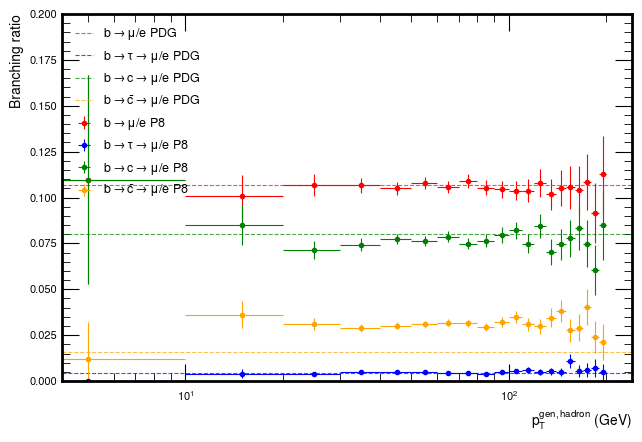

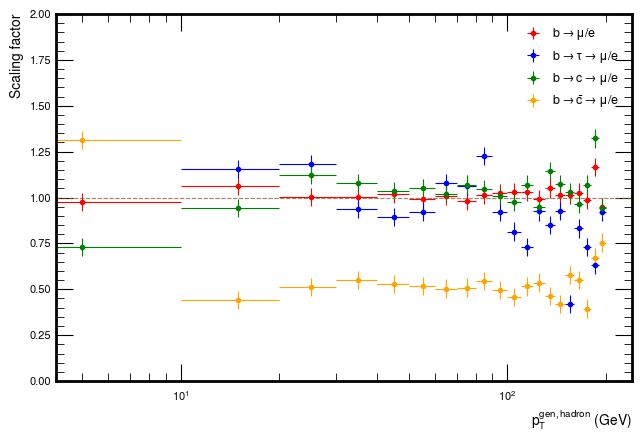

In [32]:
semileptonic.plot_results((0, 0.2))

/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_4982/3077069833.py:115: RuntimeWarning: divide by zero encountered in divide
  k: np.array(self.branching_ratio_pdg[k]) / np.array(self.branching_ratio_p8[k])


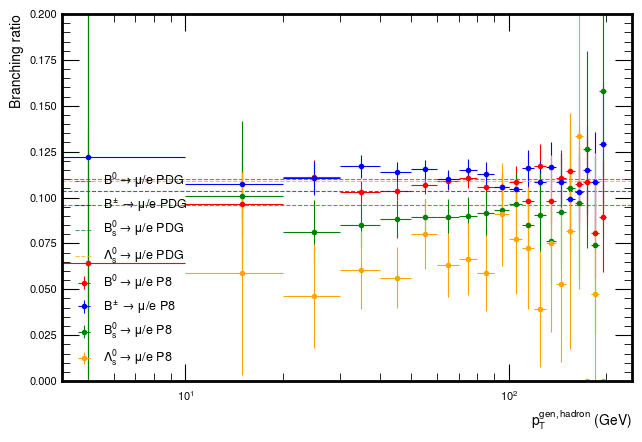

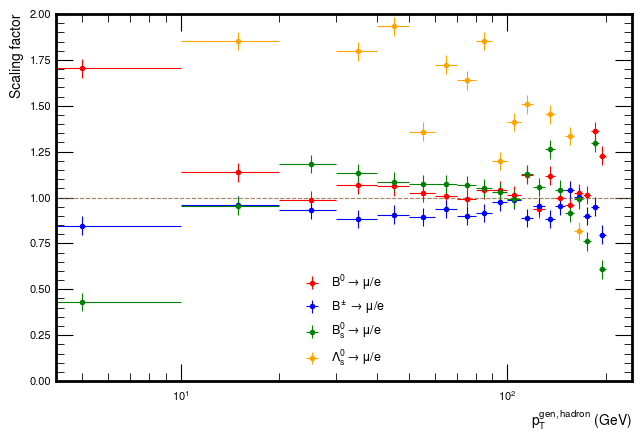

In [33]:
# Plots for specific hadrons
semileptonic_ind.plot_results((0,0.2))

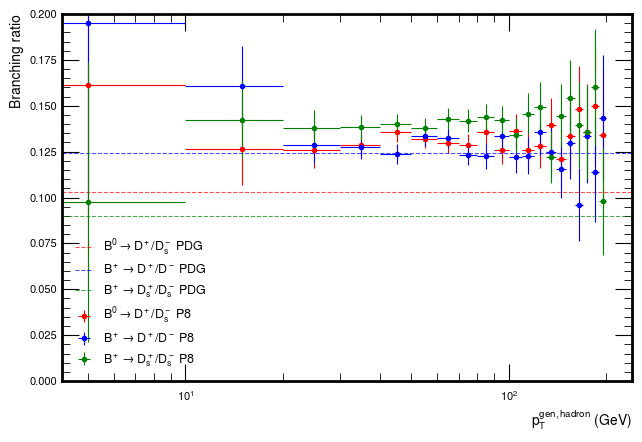

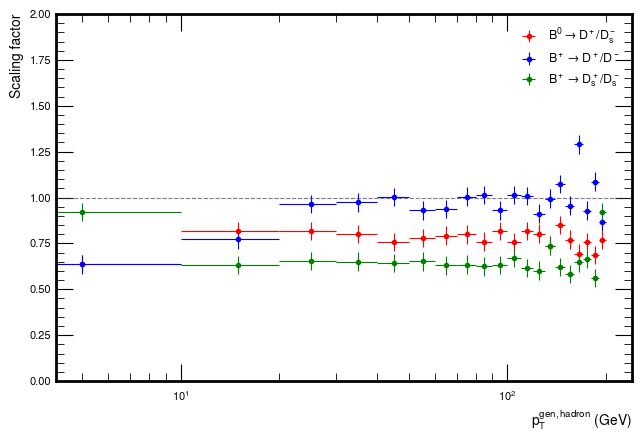

In [34]:
inclusive.plot_results((0,0.2))

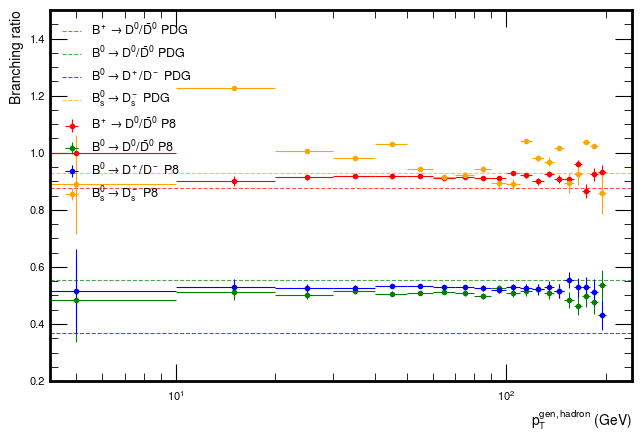

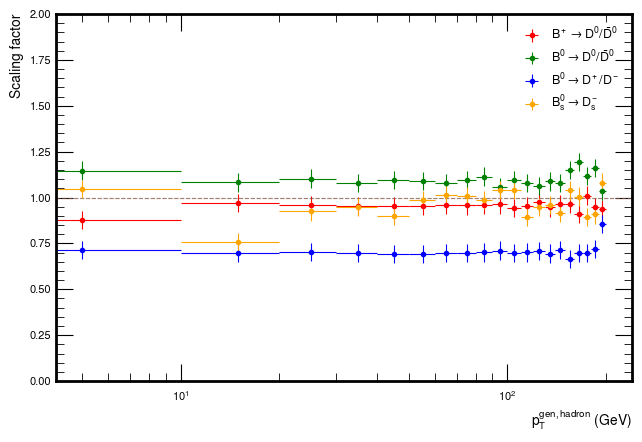

In [35]:
inclusive2.plot_results((0.2, 1.5))